<a href="https://colab.research.google.com/github/kaustubhydv/Powell-Dogleg-/blob/main/Powell_Dogleg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
from numpy.linalg import inv,det
import matplotlib.pyplot as plt
import copy
import matplotlib.pyplot as plt
import numpy.linalg as ln
import scipy as sp
from math import sqrt  

epsilon = 10**-6
NUM_ITER = 15000
x_history = []

delta_bar = 1
delta0 = 0.5
eta = 0.2

In [ ]:
def norm(vec):
  return (vec[0]**2 + vec[1]**2)**0.5

def del_f_delxj(f,j,x_star,h=0.001):
  ej = np.zeros(x_star.shape[0])
  ej[j] = 1
  return (f(x_star+h*ej) - f(x_star-h*ej))/(2*h)

def gradient(f,x_input):
  x_star = np.asarray(x_input)
  return np.asarray([del_f_delxj(f,j,x_star) for j in range(x_star.shape[0])])


def del2f_delxi2(f,x_star,i,delxi=0.001):
  x_starp = np.copy(x_star)
  x_starp[i] = x_starp[i] + delxi
  x_starm = np.copy(x_star)
  x_starm[i] = x_starm[i] - delxi
  return (f(x_starp)-2*f(x_star)+f(x_starm))/(delxi**2)
  



def del2f_delxixj(f,x_star,i,j,delxi=0.001,delxj=0.001):
  x_starA = np.copy(x_star)
  x_starA[i] += delxi
  x_starA[j] += delxj 
  
  x_starB = np.copy(x_star)
  x_starB[i] -= delxi
  x_starB[j] -= delxj 
  
  x_starC = np.copy(x_star)
  x_starC[i] -= delxi
  x_starC[j] += delxj 
  
  x_starD = np.copy(x_star)
  x_starD[i] += delxi
  x_starD[j] -= delxj 

  A = f(x_starA)
  B = f(x_starB)
  C = f(x_starC)
  D = f(x_starD)

  return (A+B-C-D)/(4*delxi*delxj)



def hessian(f,x_input):
  x_star = np.asarray(x_input)
  n = x_star.shape[0]

  g = np.zeros((n,n))

  for i in range(n):
    for j in range(n):
      if i==j:
        g[i][j] = del2f_delxi2(f,x_star,i,delxi=0.001)
      else:
        g[i][j] = del2f_delxixj(f,x_star,i,j,delxi=0.001,delxj=0.001)
  return g

In [ ]:
def func(x_input):
    """
    --------------------------------------------------------
    Write your logic to evaluate the function value. 

    Input parameters:
        x: input column vector (a numpy array of n dimension)

    Returns:
        y : Value of the function given in the problem at x.
        
    --------------------------------------------------------
    """
    
    # Start your code here
    
    y = x_input[0]**2 + x_input[1]**2 + (0.5*x_input[0] + x_input[1])**2 + (0.5*x_input[0] + x_input[1])**4 
    #y =  (x_input[0]-1)**2 + (x_input[1]-1)**2 - x_input[0]*x_input[1]
    # End your code here
    
    return y

def powdogleg_method(xk,deltak,func):
    grad = gradient(func,xk)
    hess = hessian(func,xk)
    Ck = np.linalg.inv(hess)
    pN = -np.dot(Ck, grad)
    norm_pN = sqrt(np.dot(pN, pN))

    if norm_pN <= deltak:
      return pN
    
    pC = - (np.dot(grad, grad) / np.dot(grad, np.dot(hess, grad))) * grad
    dot_pC = np.dot(pC, pC)
    norm_pC = sqrt(dot_pC)
  
    if norm_pC >= deltak:
      return deltak * pC / norm_pC
    
    pn_pc = pN-pC
    theta = ( -np.dot(pn_pc,pC) + (np.dot(pn_pc,pC)**2 +  (deltak**2 - norm_pC**2) * (np.dot(pn_pc,pn_pc)))**0.5 )/np.dot(pn_pc,pn_pc)
    pN_pC = theta*pN + (1-theta)*pC
    return pN_pC

def TRPD(func, x0):
    x0 = x0.T[0]
    x_history.append(x0)
    xk = x0
    deltak = delta0
    counter = 0
    while counter<=NUM_ITER and norm(gradient(func,x_history[-1]))**2>epsilon:
        grad = gradient(func,xk)
        hess = hessian(func,xk)
        Ck = np.linalg.inv(hess)
        pk = powdogleg_method(x_history[-1],deltak,func)
        act_red = func(xk) - func(xk + pk)
        pred_red = -(np.dot(grad, pk) + 0.5 * np.dot(pk, np.dot(hess, pk)))
        rhok = act_red / pred_red
        norm_pk = sqrt(np.dot(pk, pk))
        if rhok < 0.25:
            deltak = 0.25 * norm_pk
        else: 
            if rhok > 0.75 and norm_pk == deltak:
                deltak = min(2.0*deltak, delta_bar)
            else:
                deltak = deltak
        if rhok > eta:
            xk = xk + pk
        else:
            xk = xk
        x_history.append(xk)
       
        counter = counter + 1

    if counter == NUM_ITER:
      print('Maximum iterations reached but convergence did not happen \n')
    
    x_output = np.asarray([x_history[-1]]).T
    f_output = func(x_output)[0]
    grad_output = np.asarray([gradient(func,x_history[-1])]).T

    return x_output, f_output, grad_output

In [ ]:
x_initial = np.array([[1.5, 1.5]]).T

x_output, f_output, grad_output = TRPD(func, x_initial)

print("\n\nTrust Region - Powell Dogleg Method:")
print("-"*40)
print("\nFunction converged at x = \n",x_output)
print("\nFunction value at converged point = \n",f_output)
print("\nGradient value at converged point = \n",grad_output)



Trust Region - Powell Dogleg Method:
----------------------------------------

Function converged at x = 
 [[8.68881531e-07]
 [1.71550440e-06]]

Function value at converged point = 
 8.320174694924055e-12

Gradient value at converged point = 
 [[3.88770930e-06]
 [7.73090774e-06]]


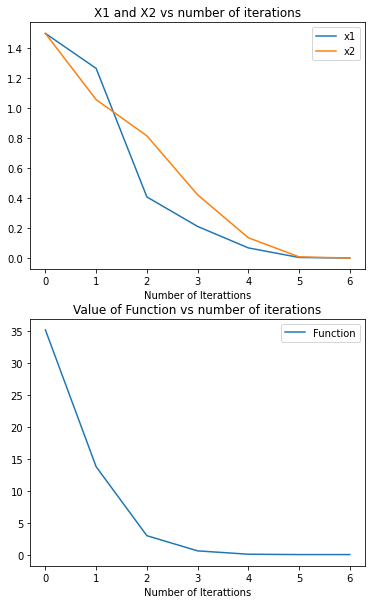

In [ ]:
fig, axis = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(6)
x1 = [x[0] for x in x_history]
x2 = [x[1] for x in x_history]
f = [func(x) for x in x_history ]
axis[0].plot(x1,label='x1')
axis[0].plot(x2,label='x2')
axis[0].set_xlabel('Number of Iterattions')
axis[0].set_title('X1 and X2 vs number of iterations')
axis[0].legend()

axis[1].set_xlabel('Number of Iterattions')
axis[1].set_title('Value of Function vs number of iterations')
axis[1].plot(f,label='Function')
axis[1].legend()
plt.show()